In [72]:
# Dependencies
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import tqdm
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# NOTE: This entire notebook takes approx. 47 minutes to run from top to bottom


# Evaluate Function

Notes from class activity:
    
Since we will be trying lots of different models, it would be nice to have a single function that will evaluate all our models and provide a standardized reporting format.

This will allow us to easily pick out the model we want to move forward with.

This function takes in a model ( pipeline ) and our train test split data. From there it simply performes predictions and generates results

In [2]:
def evaluate(pipeline, X_train, X_test, y_train, y_test):
    '''
    Evaluate a pipeline on training and test datasets
    '''    
    pipeline.fit(X_train, y_train)
    y_train_hat = pipeline.predict(X_train)
    y_test_hat = pipeline.predict(X_test)
    train_f1 = f1_score(y_train_hat, y_train,average='micro')
    train_acc = accuracy_score(y_train_hat, y_train)
    test_f1 = f1_score(y_test_hat, y_test, average='micro')
    test_acc = accuracy_score(y_test_hat, y_test)

    print(f"========== Predictor: {type(pipeline).__name__} ==========")
    print(f"Training result: f1: {train_f1:.3f}, acc: {train_acc:.3f}")
    print(f"Test result: f1: {test_f1:.3f}, acc: {test_acc:.3f}")
    print()
    

# Data

In [3]:
# Name of the CSV file
file = '../Resources/FINAL_CLEAN_FILE.csv'


In [4]:
data = pd.read_csv(file)


In [5]:
data


,VAERS_ID,SYMPTOM,ASSIGNED_GROUP,SEVERITY_LEVEL,HOSPITAL,AGE_YRS,AGE_GROUP,OTHER_MEDS,CUR_ILL,HISTORY,...,VAX_SITE_RA,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
0,916600,Dysphagia,Difficulty swallowing,MILD,0.0,33.0,26-35,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
1,917168,Dysphagia,Difficulty swallowing,MILD,0.0,64.0,56-65,1.0,0.0,1.0,...,1.0,0,0,0,0,1,0,0,0,0
2,918386,Dysphagia,Difficulty swallowing,MILD,0.0,62.0,56-65,1.0,0.0,0.0,...,1.0,0,0,0,0,1,0,0,0,0
3,918393,Dysphagia,Difficulty swallowing,MILD,0.0,62.0,56-65,1.0,0.0,0.0,...,1.0,0,0,0,0,1,0,0,0,0
4,918479,Dysphagia,Difficulty swallowing,MILD,0.0,37.0,36-45,1.0,1.0,1.0,...,1.0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26477,1094159,Peripheral paralysis,Arterial,SEVERE,1.0,67.0,66-75,1.0,0.0,1.0,...,0.0,0,0,0,0,0,1,0,0,0
26478,1094332,Arthrogram,Joint Pain/Discomfort,MILD,1.0,82.0,76-85,1.0,1.0,1.0,...,1.0,0,0,0,0,0,0,1,0,0
26479,1095188,Brachial artery entrapment syndrome,Arterial,SEVERE,0.0,77.0,76-85,1.0,1.0,1.0,...,1.0,0,0,0,0,0,0,1,0,0
26480,1100479,Visual acuity reduced,Alterred Vision,MODERATE,0.0,85.0,76-85,0.0,0.0,1.0,...,1.0,0,0,0,0,0,0,1,0,0


In [6]:
data.groupby(['SEVERITY_LEVEL']).count()


,VAERS_ID,SYMPTOM,ASSIGNED_GROUP,HOSPITAL,AGE_YRS,AGE_GROUP,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,...,VAX_SITE_RA,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
SEVERITY_LEVEL,,,,,,,,,,,,,,,,,,,,,
MILD,23836,23836,23836,23836,23836,23836,23836,23836,23836,23836,...,23836,23836,23836,23836,23836,23836,23836,23836,23836,23836
MODERATE,1984,1984,1984,1984,1984,1984,1984,1984,1984,1984,...,1984,1984,1984,1984,1984,1984,1984,1984,1984,1984
SEVERE,662,662,662,662,662,662,662,662,662,662,...,662,662,662,662,662,662,662,662,662,662


In [7]:

data.columns

Index(['VAERS_ID', 'SYMPTOM', 'ASSIGNED_GROUP', 'SEVERITY_LEVEL', 'HOSPITAL',
       'AGE_YRS', 'AGE_GROUP', 'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX',
       'ALLERGIES', 'F', 'M', 'JANSSEN', 'MODERNA', 'PFIZER',
       'VAX_DOSE_SERIES_1', 'VAX_DOSE_SERIES_2', 'VAX_SITE_LA', 'VAX_SITE_RA',
       '18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95',
       '96 +'],
      dtype='object')

In [8]:
view_correlation = data[['VAERS_ID','SYMPTOM', 'ASSIGNED_GROUP', 'SEVERITY_LEVEL', 'HOSPITAL', 'AGE_YRS', 'AGE_GROUP', 'OTHER_MEDS',
                        'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES', 'F', 'M', 'JANSSEN', 'MODERNA', 'PFIZER', 
                        'VAX_DOSE_SERIES_1', 'VAX_DOSE_SERIES_2', 'VAX_SITE_LA', 'VAX_SITE_RA']]

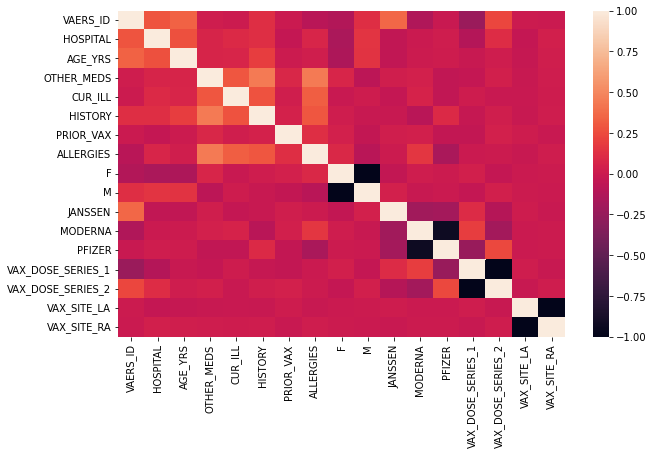

In [9]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(view_correlation.corr())
plt.show()


## Extract Features from Results

In [10]:
data.drop(['SYMPTOM', 'ASSIGNED_GROUP', 'HOSPITAL', 'AGE_YRS', 'AGE_GROUP'], axis=1, inplace=True)


In [11]:
clean_data = data.drop_duplicates(subset=['VAERS_ID', 'SEVERITY_LEVEL'])


In [12]:
clean_data


,VAERS_ID,SEVERITY_LEVEL,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,ALLERGIES,F,M,JANSSEN,...,VAX_SITE_RA,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
0,916600,MILD,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
1,917168,MILD,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0,0,0,0,1,0,0,0,0
2,918386,MILD,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0,0,0,0,1,0,0,0,0
3,918393,MILD,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0,0,0,0,1,0,0,0,0
4,918479,MILD,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26476,1098942,MODERATE,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0,1,0,0,0,0,0,0,0
26477,1094159,SEVERE,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0,0,0,0,0,1,0,0,0
26479,1095188,SEVERE,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0,0,0,0,0,0,1,0,0
26480,1100479,MODERATE,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0,0,0,0,0,0,1,0,0


In [13]:
X = clean_data.drop(['VAERS_ID', 'SEVERITY_LEVEL','VAX_SITE_LA', 'VAX_SITE_RA'], axis=1)
X


,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,ALLERGIES,F,M,JANSSEN,MODERNA,PFIZER,...,VAX_DOSE_SERIES_2,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0,0,0,0,1,0,0,0,0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0,0,0,0,1,0,0,0,0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0,0,0,0,1,0,0,0,0
4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26476,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
26477,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0,0,0,0,0,1,0,0,0
26479,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0,0,0,0,0,0,1,0,0
26480,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0,0,0,0,0,0,1,0,0


In [14]:
y = LabelEncoder().fit_transform(clean_data['SEVERITY_LEVEL'])
y


array([0, 0, 0, ..., 2, 1, 1])

In [15]:
# make sure there is no nan
# if there is nan, you need to deal with it, either by imputing or discarding
clean_data.isnull().sum(axis = 0)


VAERS_ID             0
SEVERITY_LEVEL       0
OTHER_MEDS           0
CUR_ILL              0
HISTORY              0
PRIOR_VAX            0
ALLERGIES            0
F                    0
M                    0
JANSSEN              0
MODERNA              0
PFIZER               0
VAX_DOSE_SERIES_1    0
VAX_DOSE_SERIES_2    0
VAX_SITE_LA          0
VAX_SITE_RA          0
18-25                0
26-35                0
36-45                0
46-55                0
56-65                0
66-75                0
76-85                0
86-95                0
96 +                 0
dtype: int64

## Train Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Pick a Model for a Base Point to Evaluate Other Models Against

In [17]:
# try LogisticRegression to establish a baseline performance
pipeline = Pipeline([
#     ('scale', StandardScaler()), # remember to scale first before feeding data into lgr
    ('lgr', LogisticRegression())
])
evaluate(pipeline, X_train, X_test, y_train, y_test)


========== Predictor: Pipeline ==========
Training result: f1: 0.880, acc: 0.880
Test result: f1: 0.879, acc: 0.879



In [18]:
# try other predictors
evaluate(XGBClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(LGBMClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(RandomForestClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(GradientBoostingClassifier(), X_train, X_test, y_train, y_test)


[19:37:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
========== Predictor: XGBClassifier ==========
Training result: f1: 0.881, acc: 0.881
Test result: f1: 0.879, acc: 0.879

========== Predictor: LGBMClassifier ==========
Training result: f1: 0.880, acc: 0.880
Test result: f1: 0.879, acc: 0.879

========== Predictor: RandomForestClassifier ==========
Training result: f1: 0.883, acc: 0.883
Test result: f1: 0.873, acc: 0.873

========== Predictor: GradientBoostingClassifier ==========
Training result: f1: 0.880, acc: 0.880
Test result: f1: 0.879, acc: 0.879



From the above evaluations, it looks like LGBMClassifier and GradientBoostingClassifier are the best candidates in terms of f1 score on test data

Let's hypertune the RandomForestClassifier model

In [19]:
# Tuning Object
# RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


The RandomizedSearchCV function will try all our combinations above and select the most accurate model.

That best model is found in the bestestimator property of the RandomizedSerachCV object.

In [20]:
predictor = RandomForestClassifier()
rs = RandomizedSearchCV(predictor, random_grid, cv=5, scoring='f1', n_jobs=-1, n_iter=100, verbose=1)
rs.fit(X_train, y_train)
evaluate(rs.best_estimator_, X_train, X_test, y_train, y_test)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
========== Predictor: RandomForestClassifier ==========
Training result: f1: 0.881, acc: 0.881
Test result: f1: 0.878, acc: 0.878



In [21]:
predictor.get_params().keys()


dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [22]:
rs.best_params_


{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

Let's hypertune the GradientBoostingClassifier model

In [23]:
gb_grid = {"n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]}


In [24]:
predictor2 = GradientBoostingClassifier()
cv = RandomizedSearchCV(predictor2, gb_grid, cv=5, scoring='f1', n_jobs=-1, n_iter=100, verbose=1)
cv.fit(X_train, y_train)
evaluate(cv.best_estimator_, X_train, X_test, y_train, y_test)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
========== Predictor: GradientBoostingClassifier ==========
Training result: f1: 0.880, acc: 0.880
Test result: f1: 0.879, acc: 0.879



In [25]:
cv.best_params_


{'n_estimators': 5, 'max_depth': 1, 'learning_rate': 0.01}

Let's hypertune the LGBMClassifier model

In [26]:
lgbm_grid = {

        'n_estimators': [50,100,500],
        'max_depth': [-1,1,5],
        'min_data_in_leaf': [90, 120],
        'num_leaves': [5,50,250,500,1000,2000]

}


In [27]:
predictor3 = LGBMClassifier()
lgcv = RandomizedSearchCV(predictor3, lgbm_grid, cv=5, scoring='f1', n_jobs=-1, n_iter=100, verbose=1)
lgcv.fit(X_train, y_train)
evaluate(lgcv.best_estimator_, X_train, X_test, y_train, y_test)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
========== Predictor: LGBMClassifier ==========
Training result: f1: 0.880, acc: 0.880
Test result: f1: 0.879, acc: 0.879



In [28]:
lgcv.best_params_


{'num_leaves': 5, 'n_estimators': 500, 'min_data_in_leaf': 90, 'max_depth': 5}

Let's hypertune the XGBClassifier model

In [29]:
# RandomizedSearchCV on XGB
xgb_param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 400],
    'max_depth': np.arange(5, 20),
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': np.arange(0.5, 1.0, 0.05),
    'min_child_weight': np.arange(1, 10),
    'colsample_bytree': np.arange(0.2, 1.0, 0.1),
    'gamma': [0, 0.001, 0.002, 0.003, 0.004, 0.005, 1e-2],
    'n_jobs': [-1]
}


In [30]:
predictor4 = XGBClassifier()
xrs = RandomizedSearchCV(predictor4, xgb_param_grid, cv=5, scoring='f1', n_jobs=-1, n_iter=100, verbose=1)
xrs.fit(X_train, y_train)
evaluate(xrs.best_estimator_, X_train, X_test, y_train, y_test)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[20:24:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
========== Predictor: XGBClassifier ==========
Training result: f1: 0.880, acc: 0.880
Test result: f1: 0.879, acc: 0.879



In [31]:
xrs.best_params_


{'subsample': 0.8000000000000003,
 'n_jobs': -1,
 'n_estimators': 20,
 'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.05,
 'gamma': 0.001,
 'colsample_bytree': 0.5000000000000001}

## Evaluate further

In [52]:
# Shuffle data over and over and apply our new model to the results to further determine if we want to use this model
# evaluate model with kfold
kfold = KFold(n_splits=10)
results = cross_val_score(rs.best_estimator_, X, y, cv=kfold, n_jobs=-1)
print("Results: %.2f (%.2f) accuracy" % (results.mean(), results.std()))


Results: 0.88 (0.15) accuracy


In [53]:
kfold2 = KFold(n_splits=10)
results2 = cross_val_score(cv.best_estimator_, X, y, cv=kfold2, n_jobs=-1)
print("Results: %.2f (%.2f) accuracy" % (results2.mean(), results2.std()))


Results: 0.88 (0.15) accuracy


In [54]:
kfold3 = KFold(n_splits=10)
results3 = cross_val_score(lgcv.best_estimator_, X, y, cv=kfold3, n_jobs=-1)
print("Results: %.2f (%.2f) accuracy" % (results3.mean(), results3.std()))


Results: 0.88 (0.15) accuracy


In [55]:
kfold4 = KFold(n_splits=10)
results4 = cross_val_score(xrs.best_estimator_, X, y, cv=kfold4, n_jobs=-1)
print("Results: %.2f (%.2f) accuracy" % (results4.mean(), results4.std()))


Results: 0.88 (0.15) accuracy


# Save The Model For Future Use

In [56]:
# save model
with open(f'best_classifier_model.pickle', 'wb') as f:
    pickle.dump(xrs.best_estimator_, f)
    

# Predict

In [64]:
with open('best_classifier_model.pickle', "rb") as f:
    model = pickle.load(f)
    

In [57]:
X


,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,ALLERGIES,F,M,JANSSEN,MODERNA,PFIZER,...,VAX_DOSE_SERIES_2,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0,0,0,0,1,0,0,0,0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0,0,0,0,1,0,0,0,0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0,0,0,0,1,0,0,0,0
4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26476,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
26477,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0,0,0,0,0,1,0,0,0
26479,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0,0,0,0,0,0,1,0,0
26480,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0,0,0,0,0,0,1,0,0


In [77]:
predictions = model.predict(X)
mylist = np.array(predictions)

result = np.where(mylist == 2)

print('Tuple of arrays returned : ', result)
print("Elements with value 19 exists at following indices", result[0], sep='\n')


Tuple of arrays returned :  (array([], dtype=int64),)
Elements with value 19 exists at following indices
[]


In [58]:
X.columns


Index(['OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES', 'F', 'M',
       'JANSSEN', 'MODERNA', 'PFIZER', 'VAX_DOSE_SERIES_1',
       'VAX_DOSE_SERIES_2', '18-25', '26-35', '36-45', '46-55', '56-65',
       '66-75', '76-85', '86-95', '96 +'],
      dtype='object')

In [59]:
np.zeros(len(X.columns))


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [60]:
features_np = ['OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES', 'F', 'M', 'JANSSEN', 'MODERNA', 'PFIZER',
       'VAX_DOSE_SERIES_1', 'VAX_DOSE_SERIES_2', '18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95',
       '96 +']
user_input = np.zeros(len(features_np))


In [66]:
age_group = '36-45'
sex = 'F'
other_meds = 0
cur_ill = 0
history = 0
prior_vax = 0
allergies = 0
vax_name = 'PFIZER'
vax_dose = '2'

age_idx = features_np.index(f'{age_group}')
sex_idx = features_np.index(f'{sex}')
vax_idx = features_np.index(f'{vax_name}')
dose_idx = features_np.index(f'VAX_DOSE_SERIES_{vax_dose}')

user_input[0] = other_meds
user_input[1] = cur_ill
user_input[2] = history
user_input[3] = prior_vax
user_input[4] = allergies
user_input[sex_idx] = 1
user_input[vax_idx] = 1
user_input[dose_idx] = 1
user_input[age_idx] = 1


print(user_input)


[0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [65]:
model.predict(user_input)


XGBoostError: [20:48:45] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/predictor/cpu_predictor.cc:341: Check failed: m->NumColumns() == model.learner_model_param->num_feature (1 vs. 21) : Number of columns in data must equal to trained model.

# Define function to predict on user input

In [63]:
def makepredictions(gender, age, seniority, jobTitle, educ):
    features_np = ['Gender', 'Age', 'Seniority', 'JobTitle_Data Scientist',
       'JobTitle_Driver', 'JobTitle_Financial Analyst',
       'JobTitle_Graphic Designer', 'JobTitle_IT', 'JobTitle_Manager',
       'JobTitle_Marketing Associate', 'JobTitle_Sales Associate',
       'JobTitle_Software Engineer', 'JobTitle_Warehouse Associate',
       'Education_College', 'Education_High School', 'Education_Masters',
       'Education_PhD']
    
    user_input = np.zeros(len(features_np))
    user_input2 = np.zeros(len(features_np))
    
    job_idx = features_np.index(f'JobTitle_{jobTitle}')
    ed_idx = features_np.index(f'Education_{educ}')


    user_input[0] = gender
    user_input[1] = age
    user_input[2] = seniority
    user_input[job_idx] = 1
    user_input[ed_idx] = 1

    user_input2[0] = 1 if gender == 0 else 0
    user_input2[1] = age
    user_input2[2] = seniority
    user_input2[job_idx] = 1
    user_input2[ed_idx] = 1
    
    filename = 'finalized_model3.sav'
    reg_load = pickle.load(open(filename, 'rb'))
    
    preds = reg_load.predict([user_input, user_input2])
    return preds
